Twint is an advanced Twitter scraping tool written in Python that allows for scraping Tweets from Twitter with filtering features by periods, username, keywords, language and etc. It provides various benefits such as fast setup, and no rate limitations. Therefore, I used Twint for data extraction. 

More details of Twint can be found in this github repository: https://github.com/twintproject/twint

In [49]:
import twint
import nest_asyncio

import json
import pandas as pd
from pandas.io.json import json_normalize
import re
import emoji

from collections import Counter
from urlextract import URLExtract
import unicodedata

from difflib import SequenceMatcher

## 1. Data collection using keywords and relevant periods 

This analysis focuses on specific tweets by applying keywords and periods conditions instead of collecting th entire tweets in history, for more practical and better quality analysis. 

Twint is used as a data extraction tool, which is an advanced Twitter scraping tool written in Python that allows for scraping Tweets from Twitter with filtering features by periods, username, keywords, language and etc. It provides various benefits such as fast setup, and no rate limitations.

More details of Twint can be found in this github repository: https://github.com/twintproject/twint

In [13]:
def extractTweet(keywords, start_date='2019-12-01', end_date= '2019-12-31', file_name='output.csv', csv = True, 
                 limit_row = None):
    config = twint.Config()
    
    if limit_row is not None:
        config.Limit = limit_row 
    
    config.Search = keywords
    config.Lang = 'en'
    config.Since= start_date
    config.Until= end_date
    config.Store_csv = True
    config.Output = file_name
    config.Retweets = False 
    config.Hide_output = True 
    
    #running search
    nest_asyncio.apply()
    twint.run.Search(config)

In [14]:
extractTweet("apple", limit_row = 30)

## 2. Data Filtering 

To identify and focus data that  are relevant to first person experience or opinion, duplicated tweets, futher filtering is applied. 
    - remove duplicates and retweets (tweets containing 'RT')
    - remove tweets contining URLs (often they are advertisements or Spam) 
    - remove tweets very similar to another (can be retweet without a sign of “RT” or spam, or advertisement)  

In [19]:
file_name = 'bDMARDs_output.csv' 
pdf = pd.read_csv(file_name)
pdf = pdf[['date', 'user_id', 'place', 'tweet']]

pdf = pdf.drop_duplicates(subset = "tweet")


In [25]:
pdf['exclude_flag']  = False 

#replace URL to <URL>
extractor = URLExtract()

for idx, row in pdf.iterrows(): 
    if 'rt' in row['tweet'].lower().split():
        pdf.loc['exclude_flag', idx] = True 
    else:    
        tweet = unicodedata.normalize("NFKD", row['tweet'])
        tweet = emoji.demojize(tweet) # convert emoji defined by the unicode consortium to text 
        urls = extractor.find_urls(tweet)
        if(len(urls) > 0): 
            pdf.loc['exclude_flag', idx] = True 
                

In [29]:
filtered_pdf = pdf[pdf['exclude_flag'] == False]
filtered_pdf.sort_values('date', inplace = True)

C:\Users\Huiyeong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
#find similar tweets 
def find_similar_tweets(pdf, threshold = 0.75):
    dupIndex = list()
    for i in range(1, len(pdf)):
        ratio = SequenceMatcher(None, pdf.tweet[i-1], pdf.tweet[i]).ratio()
        if ratio >= threshold:
            dupIndex.append(i-1)
            dupIndex.append(i)
            
    dupIndex = list(set(dupIndex))
    return dupIndex 

In [39]:
dupIndex = find_similar_tweets(filtered_pdf)
while len(dupIndex) >0:
    filtered_pdf = filtered_pdf.drop(filtered_pdf.index[dupIndex])
    dupIndex = find_similar_tweets(filtered_pdf)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import numpy as np
import datetime

In [51]:
b= pd.read_csv("bDMARD without URL after data processing ver2.csv")

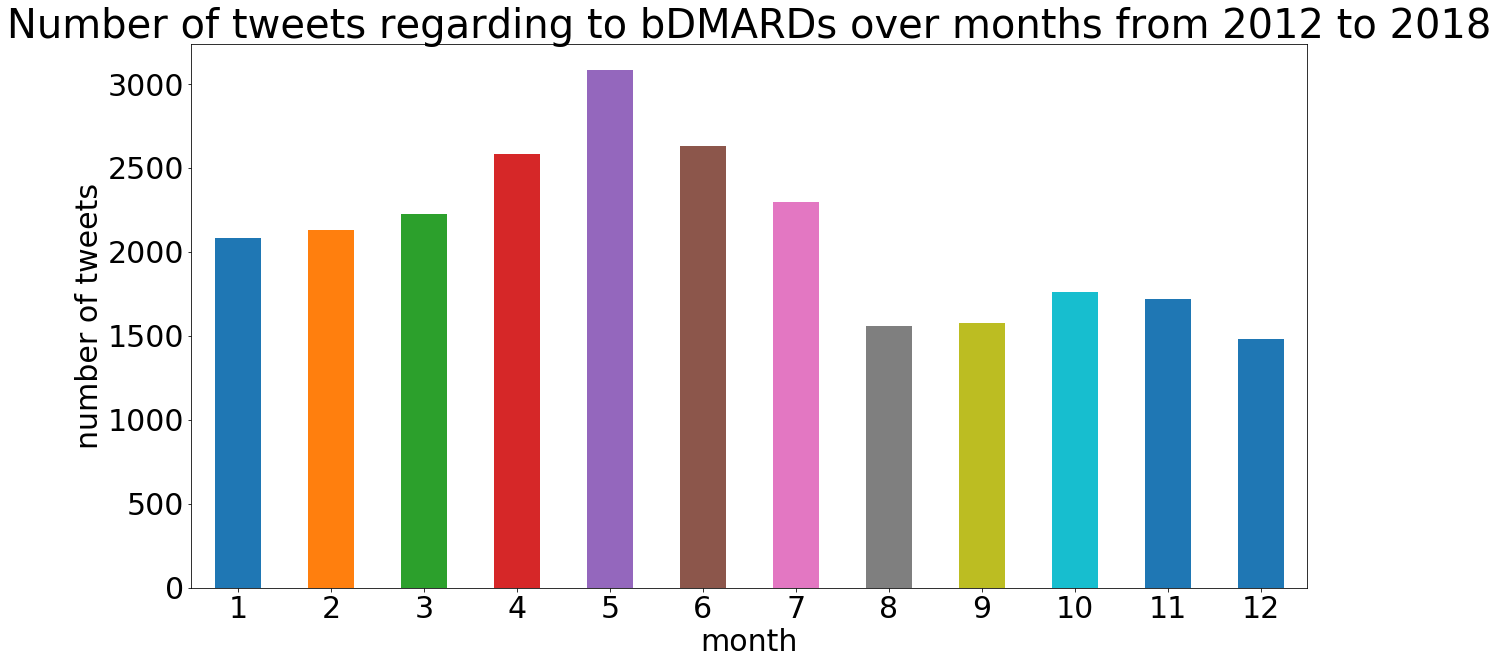

In [52]:
b['date']  = b['date'].astype("datetime64")
plt.figure(figsize=(20, 10))
ax = b['id'].groupby(b["date"].dt.month).count().plot(kind="bar")
plt.xlabel("month", fontsize = 30)
plt.ylabel("number of tweets", fontsize = 30)
plt.tick_params(labelsize=30)
plt.xticks(rotation = 0)
plt.title("Number of tweets regarding to bDMARDs over months from 2012 to 2018", fontsize = 40)

plt.show()

In [46]:
x= pd.read_csv("cDMARD without URL _Twint.csv")

In [47]:
x['date']  = x['date'].astype("datetime64")

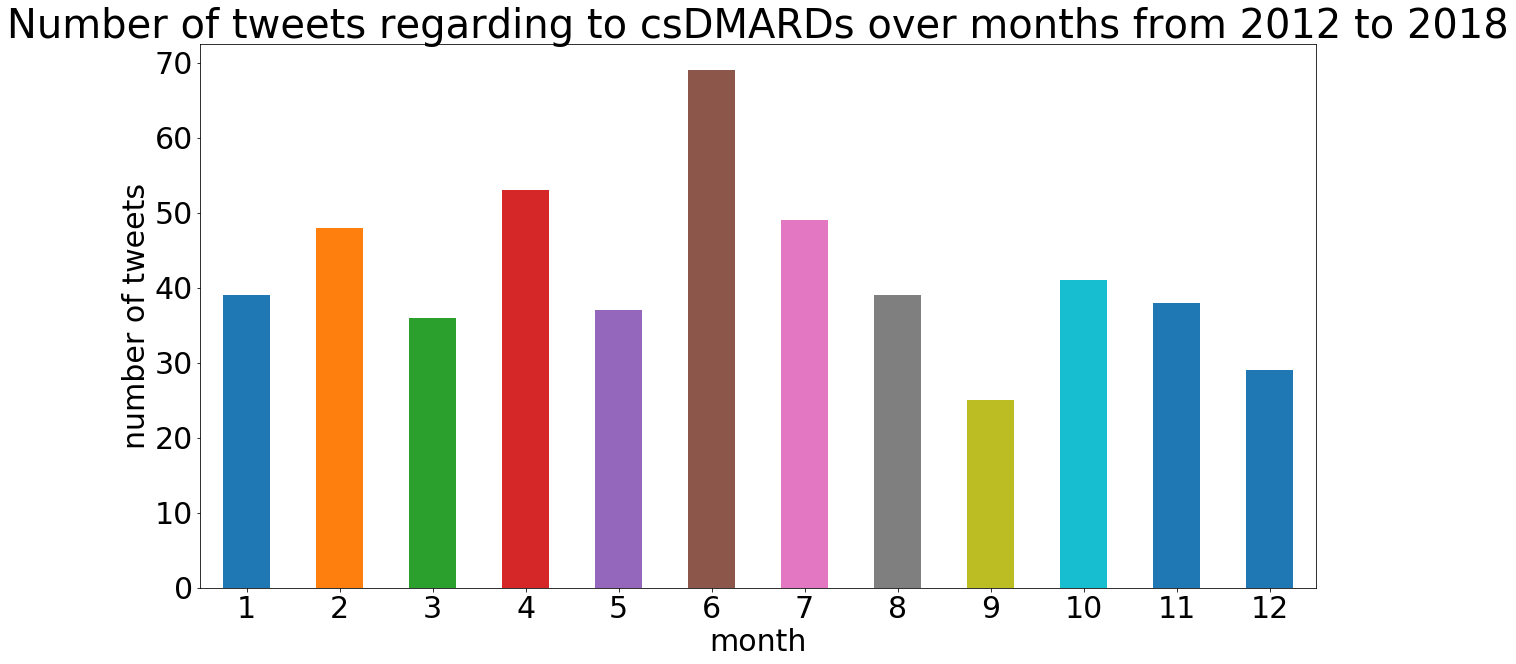

In [50]:
plt.figure(figsize=(20, 10))
x['id'].groupby(x["date"].dt.month).count().plot(kind="bar")
plt.xlabel("month", fontsize = 30)
plt.ylabel("number of tweets", fontsize = 30)
plt.tick_params(labelsize=30)
plt.xticks(rotation = 0)
#plt.Line2D()
plt.title("Number of tweets regarding to csDMARDs over months from 2012 to 2018", fontsize = 40)

plt.show()